In [37]:
%load_ext autoreload
%autoreload
%matplotlib widget
from N_xi_fit_funcs import *
import phaseco as pc
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate, get_window, convolve, correlation_lags
from scipy.optimize import curve_fit
import os
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Directories
os.chdir(r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence")
pkl_folder = r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\pickles"

In [58]:
# Get waveform
wf_idx = 2
species = "Human"
wf_len_s = 60
wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
    species=species,
    wf_idx=wf_idx,
)
wf = crop_wf(wf, fs, wf_len_s)
f0 = 8312

In [ ]:
# Set parameters
win_type = 'flattop'
bw = 5
pw = True
tau = get_precalc_tau_from_bw(bw, fs, win_type, pkl_folder)
nfft = 8192
f = rfftfreq(nfft, 1/fs)
f0_exact = np.argmin(np.abs(f-f0))

In [67]:
"Get single narrowband around f0"
win_type = 'flattop'
win = get_window(win_type, tau)

n_array = np.arange(tau)

# Get the center narrowband frequency
omega_0_norm = f0_exact * 2*np.pi / fs
kernel = win * np.exp(1j * omega_0_norm * n_array)
wf_0 = convolve(wf, kernel, mode='valid', method='fft')
wf_0 = wf_0 - np.mean(wf_0)
sigma_0 = np.std(wf_0)
N = len(wf_0)
xis = correlation_lags(N, N, mode='full')
xis_ms = xis / fs * 1000
mid_idx = len(xis)//2

# Set up the arrays for all the other ones
delta_f_max = 10
delta_f_delta = 1
delta_f0s = np.arange(-delta_f_max,delta_f_max+1, delta_f_delta)
ccfs = np.empty((2*N-1, len(delta_f0s)))
num_terms = N - np.abs(xis) # number of terms in each CCF calculation



for k, delta_f0 in enumerate(tqdm(delta_f0s)):
    omega_norm = (f0_exact+delta_f0) * 2*np.pi / fs
    kernel = win * np.exp(1j * omega_norm * n_array)
    wf_omega = convolve(wf, kernel, mode='valid', method='fft')
    wf_omega = wf_omega - np.mean(wf_omega)
    sigma = np.std(wf_omega)
    ccf = correlate(wf_0, wf_omega, mode='full', method='fft')
    ccf_norm = np.abs(ccf)/(sigma_0*sigma*num_terms)
    # print(np.max(ccf_norm))
    ccfs[:, k] = ccf_norm


100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


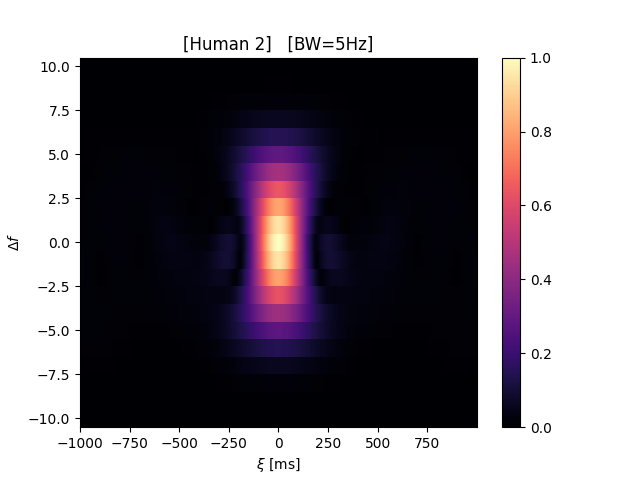

In [69]:
xi_max_ms = 1000
xi_min_ms = -xi_max_ms
xi_min_ms_idx = np.argmin(np.abs(xis_ms - xi_min_ms))
xi_max_ms_idx = np.argmin(np.abs(xis_ms - xi_max_ms))


plt.close('all')
plt.figure()

# make meshgrid
xx, yy = np.meshgrid(
    xis_ms[xi_min_ms_idx:xi_max_ms_idx], delta_f0s
)  

# plot the heatmap
vmin = 0
vmax = 1
heatmap = plt.pcolormesh(
    xx, yy, ccfs[xi_min_ms_idx:xi_max_ms_idx, :].T, vmin=vmin, vmax=vmax, cmap='magma', shading="nearest"
)

# get and set label for cbar
# cbar_label = r"$C_\xi^P$" if pw else r"$C_\xi$"
cbar = plt.colorbar(heatmap)
# cbar.set_label(cbar_label, labelpad=30)

# set axes labels and titles
plt.xlabel(rf"$\xi$ [ms]")
plt.ylabel(r"$\Delta f$")
id = f"[{species} {wf_idx}]   [BW={bw}Hz]"
fn_id = f"{species} {wf_idx}, BW={bw}, delta_f_max={delta_f_max}, delta_f_delta={delta_f_delta}.jpg"
plot_folder = f"NBCCFs"
os.makedirs(plot_folder, exist_ok=True)
plt.title(id)
plt.xlim()
plt.savefig(os.path.join(plot_folder, fn_id), dpi=200)
plt.show()